In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
import seaborn as sns

In [4]:
sns.set_context('paper', font_scale=2.2)
sns.set_style('ticks')

In [13]:
import LB_colony_growth.LB_colony_growth as lb

import skimage as ski
import skimage.draw

In [33]:
dimension = 2

workgroup_x = 32
workgroup_y = 16

halo = 1 #ALWAYS 1 for this system.

num_alleles = 2

nx = 128
ny = 128

velocity_set = 'D2Q9'

In [34]:
ctx_info = {}
ctx_info['num_type'] = 'double'

ctx_info['nx'] = nx
ctx_info['ny'] = ny
ctx_info['nz'] = None

ctx_info['local_size'] = (workgroup_x, workgroup_y)
ctx_info['domain_size'] = (nx, ny)

ctx_info['dimension'] = dimension
ctx_info['num_alleles'] = num_alleles

ctx_info['kernel_arguments'] = {}

In [35]:
bc_map = np.zeros((nx + 2*halo, ny + 2*halo), dtype=lb.int_type)

bc_map[...] = lb.FLUID_NODE

bc_map[0:halo, :] = lb.WALL_NODE
bc_map[-halo:, :] = lb.WALL_NODE
bc_map[:, 0:halo] = lb.WALL_NODE
bc_map[:, -halo:] = lb.WALL_NODE

In [36]:
R0 = 10

[r, c] = ski.draw.circle(nx/2, ny/2, R0)

rand_alleles = np.random.randint(-num_alleles, 0, size=(nx, ny))

In [37]:
bc_map[r, c] = rand_alleles[r, c]

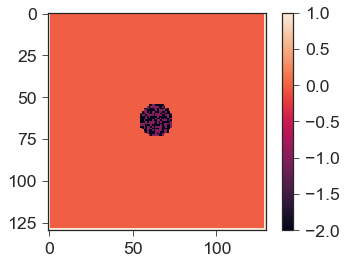

In [38]:
plt.imshow(bc_map)
plt.colorbar()

In [39]:
# Initialize rho...one everywhere, except in the circle where cells were inoculated

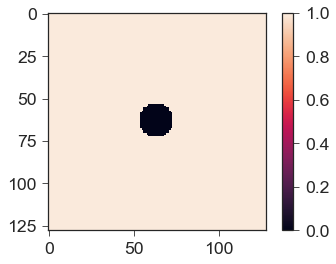

In [40]:
rho = np.ones((nx, ny), dtype=lb.num_type)
bc_in_domain = bc_map[halo:-halo, halo:-halo]

rho[bc_in_domain < 0] = 0

plt.imshow(rho)
plt.colorbar()

In [41]:
m0 = 1.0

152.22915606052783


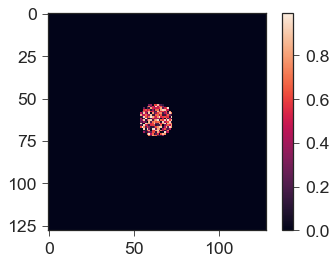

In [42]:
# Initialize the current amount of absorbed mass randomly

absorbed_mass = np.random.rand(nx, ny)
bc_in_domain = bc_map[halo:-halo, halo:-halo]

absorbed_mass[bc_in_domain >= 0] = 0

plt.imshow(absorbed_mass)
plt.colorbar()

print absorbed_mass.sum()

In [43]:
k_list = [1, 1]
m_reproduce_list = [m0, m0]
velocity_set = 'D2Q9'
D = .5 * (1./3.)

In [70]:
dla_colony = lb.DLA_Colony(
    ctx_info=ctx_info, velocity_set='D2Q9',
    bc_map=bc_map, 
    D=D, k_list=k_list, m_reproduce_list=m_reproduce_list,
    absorbed_mass=absorbed_mass, rho=rho)

global size: (128, 128)
local size: (32, 16)
The platforms detected are:
---------------------------
NVIDIA CUDA NVIDIA Corporation version: OpenCL 1.2 CUDA 9.0.282
The devices detected on platform NVIDIA CUDA are:
---------------------------
GeForce GTX TITAN Black [Type: GPU ]
Maximum clock Frequency: 980 MHz
Maximum allocable memory size: 1594 MB
Maximum work group size 1024
Maximum work item dimensions 3
Maximum work item size [1024L, 1024L, 64L]
---------------------------
This context is associated with  1 devices
tau 0.9999999999999998
omega 1.0000000000000002
global_size_bc: (160, 144)
Connecting python to the opencl_kernel init_feq...
Connecting python to the opencl_kernel collide_and_propagate...
Creating local memory of double type...
Creating local memory of int type...
Connecting python to the opencl_kernel update_after_streaming...
Connecting python to the opencl_kernel reproduce...
Creating local memory of int type...
Connecting python to the opencl_kernel copy_streamed_

In [71]:
# plt.imshow(dla_colony.f.get()[:, :, 1], interpolation='None')
# plt.colorbar()

In [72]:
# plt.imshow(dla_colony.rho.get(), interpolation=None)
# plt.colorbar()

In [73]:
# plt.imshow(dla_colony.feq.get()[:, :, 3])
# plt.colorbar()

In [74]:
# plt.imshow(dla_colony.f_streamed.get()[:, :, 1])
# plt.colorbar()
# plt.figure()
# plt.imshow(dla_colony.f_streamed.get()[:, :, 0])
# plt.colorbar()

In [75]:
dla_colony.run(200)
#dla_colony.collide_and_propagate.run().wait()

In [76]:
from matplotlib import colors

cmap = colors.ListedColormap(['white','red', 'green'])

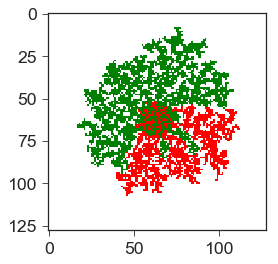

In [79]:
pops = dla_colony.get_pop_field()
plt.imshow(pops, cmap=cmap)


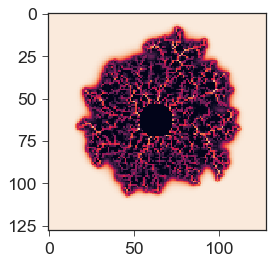

In [78]:
plt.imshow(dla_colony.rho.get())

In [76]:
# f_num = 2
# f_vel = dla_colony.velocity_set.c_vec[:, f_num]
# print 'f_vel', f_vel
# reflect_num = dla_colony.velocity_set.reflect_list[f_num]
# print 'reflect_num', reflect_num
# reflect_vel = dla_colony.velocity_set.c_vec[:, reflect_num]
# print 'reflect_vel', reflect_vel


# plt.imshow(dla_colony.f_streamed.get()[nx/2-15:nx/2 + 20, ny/2-15:ny/2+15, f_num], interpolation=None)
# plt.colorbar()

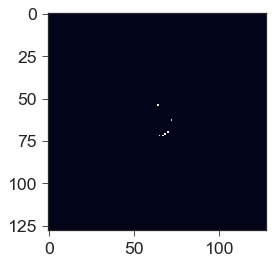

In [77]:
plt.imshow(dla_colony.absorbed_mass.get() > 1.)

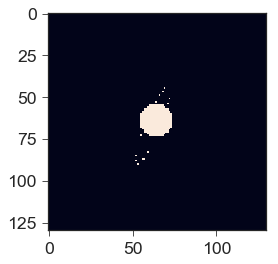

In [37]:
plt.imshow(dla_colony.bc_map_streamed.get() < 0)

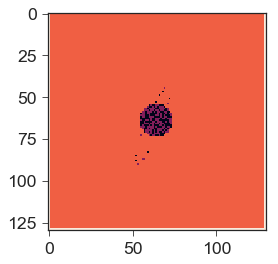

In [36]:
plt.imshow(dla_colony.bc_map.get())

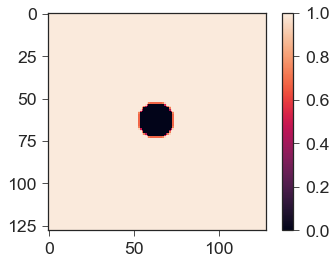

In [24]:
plt.imshow(dla_colony.rho.get())
plt.colorbar()

In [25]:
dla_colony.absorbed_mass.get().sum()

2332.193757176624

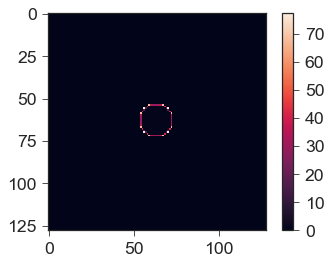

In [26]:
plt.imshow(dla_colony.absorbed_mass.get())
plt.colorbar()

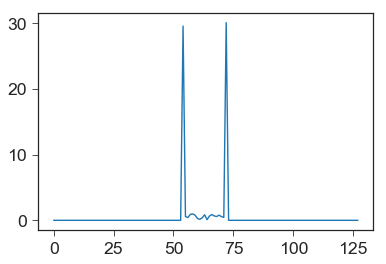

In [27]:
plt.plot(dla_colony.absorbed_mass.get()[nx/2, :])

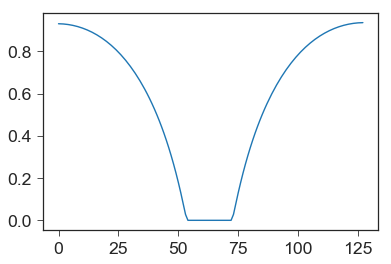

In [156]:
plt.plot(dla_colony.rho.get()[nx/2, :])

In [123]:
%%timeit

dla_colony.can_reproduce[0] = 1

10000 loops, best of 3: 60 µs per loop


In [122]:
%%timeit

dla_colony.can_reproduce.set(np.array([1], dtype=np.int32, order='F'))

The slowest run took 5.00 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 3: 37.2 µs per loop
